# Movie Hit Prediction at NeoStudio Pictures
## Part 1: Exploratory Data Analysis (EDA)

---

### Executive Summary

**Business Context**: We are data scientists at **NeoStudio Pictures**, a mid-size production company navigating an increasingly competitive film industry. Every year, executives face the critical decision: which movie projects should we greenlight? With production budgets ranging from tens to hundreds of millions of dollars, making the wrong call can be catastrophic.

**The Challenge**: Before a single frame is shot, can we predict whether a movie will become a box office hit (≥$100M worldwide revenue)?

**Our Solution**: This notebook presents the **data exploration and feature engineering** phase of our comprehensive machine learning system that analyzes pre-release movie attributes—budget, genre, cast, director, release timing—to predict box office success.

---

### What This Notebook Covers

| Section | Description | Key Deliverables |
|---------|-------------|------------------|
| **Part 1: Data Acquisition** | Load TMDB dataset, handle missing values | Clean movie database |
| **Part 2: Data Overview** | Understand data structure and types | Dataset summary |
| **Part 3: Defining Success** | Create target variable for hit classification | Hit/Non-hit labels |
| **Part 4: Exploratory Analysis** | Understand patterns, visualize distributions | Key insights about hits vs non-hits |
| **Part 5: Feature Engineering** | Create predictive features from raw data | Model-ready dataset |


### Dataset: TMDB 5000 Movies

- **Source**: [Kaggle - TMDB Movie Metadata](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
- **Files**:
  - `tmdb_5000_movies.csv` - Budget, revenue, genres, production companies
  - `tmdb_5000_credits.csv` - Cast and crew information
- **Size**: ~5,000 movies spanning multiple decades

---

**Next Step**: After completing this notebook, proceed to **`Modeling.ipynb`** for machine learning model development.


---

# Part 1: Setup & Data Acquisition

## 1.1 Environment Setup

First, we'll install and import all necessary libraries. This notebook is designed to work seamlessly in Google Colab or any local Jupyter environment.

In [ ]:
# Install required packages (automatically handled in Colab)
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm kaggle

In [ ]:
# Import core libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)
import xgboost as xgb
import lightgbm as lgb

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All packages imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" NumPy version: {np.__version__}")
print(f" Scikit-learn is ready")
print(f" XGBoost and LightGBM are ready")

 All packages imported successfully!
 Pandas version: 2.2.2
 NumPy version: 2.0.2
 Scikit-learn is ready
 XGBoost and LightGBM are ready


## 1.2 Dataset Download Options

Get TMDB dataset into this notebook.

1. Download from [Kaggle TMDB Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
2. Upload the two CSV files when prompted below

## Dataset Overview

We are using the **TMDB 5000 dataset**, a rich archive of film history. To conduct our analysis, we require **two distinct files**:

1. **tmdb_5000_movies.csv**  
   - Contains **business data**: Budgets, Revenue, Release Dates

2. **tmdb_5000_credits.csv**  
   - Contains **creative data**: Cast lists, Director names, Crew roles

These files will be uploaded to our environment to begin the **data extraction and feature engineering process**.


In [ ]:
# Create necessary directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

print("📁 Directory structure created:")
print("  - data/raw/ (for input CSV files)")
print("  - data/processed/ (for cleaned dataset)")

# Uncomment ONE of the following sections based on your preferred method:

# OPTION 1: Manual Upload (Recommended for Colab)
# ------------------------------------
from google.colab import files
print("\n📤 Please upload tmdb_5000_movies.csv:")
uploaded1 = files.upload()
print("\n📤 Please upload tmdb_5000_credits.csv:")
uploaded2 = files.upload()
print("\n✓ Files uploaded successfully!")

📁 Directory structure created:
  - data/raw/ (for input CSV files)
  - data/processed/ (for cleaned dataset)

📤 Please upload tmdb_5000_movies.csv:


Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv

📤 Please upload tmdb_5000_credits.csv:


Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv

✓ Files uploaded successfully!


## 1.3 Load and Inspect Data

Now that the files are uploaded, we can **load them into memory** and inspect the raw datasets.

---

### Movies Dataset

- Expected size: ~4,800 rows (movies)  
- Columns: ~20 metadata fields, including budgets, revenue, and release dates

---

### Credits Dataset

- Links to movies via a **unique ID**  
- Contains cast and crew information, allowing us to identify actors, directors, and other key roles

---

### Next Step

- Print the **shape** of both datasets to ensure proper loading  
- Confirm the data is ready for the **cleaning and feature engineering process**


In [ ]:
print("LOADING TMDB MOVIE DATASET")
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')
print(" Datasets loaded successfully!\n")

print(f" Movies dataset shape: {movies_df.shape}")
print(f"   - {movies_df.shape[0]:,} movies")
print(f"   - {movies_df.shape[1]} columns\n")

print(f" Credits dataset shape: {credits_df.shape}")
print(f"   - {credits_df.shape[0]:,} records")
print(f"   - {credits_df.shape[1]} columns")

LOADING TMDB MOVIE DATASET
 Datasets loaded successfully!

 Movies dataset shape: (4803, 20)
   - 4,803 movies
   - 20 columns

 Credits dataset shape: (4803, 4)
   - 4,803 records
   - 4 columns


In [ ]:
# Preview the movies dataset
if not movies_df.empty:
    print("MOVIES DATASET - FIRST GLIMPSE")
    display(movies_df.head())
    print("\n Column Overview:")
    print(movies_df.info())

MOVIES DATASET - FIRST GLIMPSE


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124



 Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  st

## What We Found

This dataset is a **gold mine**, but it requires significant refinement before it can be used effectively for modeling.

---

## The Target Variable

We observe a `revenue` column in the dataset.  
This will serve as our **North Star**.

By comparing **revenue** against **budget**, we can define precisely what constitutes a **“Hit”** using **Return on Investment (ROI)** rather than raw earnings alone.

---

## The JSON Challenge

Several columns—such as `genres`, `keywords`, and `production_companies`—are stored as **raw JSON strings**, for example:


[{"id": 28, "name": "Action"}]


Machine learning models cannot interpret these structures directly.  
We will need to perform **feature engineering** to unpack these JSON strings into usable binary or categorical features, such as:

- `is_action_movie = 1`
- `has_major_studio = 1`

---

## Missing Data

The `.info()` summary reveals some missing values:

- Columns like `tagline` and `homepage` contain nulls.

Crucially, our **key financial columns** (`budget`, `revenue`) appear mostly intact.  
We will formally verify this data integrity during the **data cleaning phase**.

---

## Strategic Insight

The `budget` variable spans an enormous range—from tiny independent films to massive blockbusters (for example, *Avatar* at approximately \$237M).

This wide variance is essential:

- It allows the model to distinguish between a **“niche hit”** and a **“global blockbuster”**
- It improves the model’s ability to generalize across different scales of film production




In [ ]:
# Preview the credits dataset
if not credits_df.empty:
    print("CREDITS DATASET - FIRST GLIMPSE")
    display(credits_df.head())

    print("\n Column Overview:")
    print(credits_df.info())

CREDITS DATASET - FIRST GLIMPSE


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."



 Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
None


## What We Found

This dataset holds the **“Creative DNA”** of the films, but much of that value is currently locked inside complex, nested structures.

---

## The Bridge

The `movie_id` column exists in this dataset.  
This is the **critical key** we will use to link the **Cast & Crew data** with the **Financial data** in the next step.

---

## Hidden Value

The `cast` and `crew` columns contain **large, nested lists** of information that are not immediately usable in their raw form.

### Cast
- Embedded within the cast data is a potential **“Star Power”** metric.
- By extracting the **top-billed actors**, we can test whether the presence of specific **A-list actors** correlates with a higher probability of a box-office hit.

### Crew
- The crew data contains information about key contributors, most importantly the **Director**.
- Our hypothesis is that the **Director** is the single most predictive human factor in determining a film’s success.

---

## The Plan

Analyzing these datasets separately limits their effectiveness.  
In **Part 2**, we will **merge these datasets** to create a single **Master Record** for each movie, directly linking **financial performance** to **creative talent**.


---

# Part 2: Data Cleaning & Preparation

## 2.1 Merge Datasets

The movies and credits datasets contain complementary information. We'll merge them to create a unified dataset for analysis.

In [ ]:
if not movies_df.empty and not credits_df.empty:
    print("MERGING DATASETS")

    # Determine merge key
    if 'id' in movies_df.columns and 'movie_id' in credits_df.columns:
        df = movies_df.merge(credits_df, left_on='id', right_on='movie_id', how='inner')
        print(" Merged on: movies.id = credits.movie_id")
    elif 'id' in movies_df.columns and 'id' in credits_df.columns:
        df = movies_df.merge(credits_df, on='id', how='inner')
        print(" Merged on: id (common column)")
    else:
        print("  Warning: Could not find common merge key")
        df = movies_df  # Fallback to movies only

    print(f"\n Merged dataset shape: {df.shape}")
    print(f"   - {df.shape[0]:,} movies")
    print(f"   - {df.shape[1]} total columns")
    print("\n Datasets successfully merged!")

MERGING DATASETS
 Merged on: movies.id = credits.movie_id

 Merged dataset shape: (4803, 24)
   - 4,803 movies
   - 24 total columns

 Datasets successfully merged!


## Data Integration Complete

We have successfully fused the **financial ledger** with the **talent ledger**.

---

## Result

We now have a **single dataframe** containing **24 columns** for every movie.

---

## Why This Matters

This unified dataset allows us to ask questions that span both creative and financial domains, such as:

- Do movies with higher budgets (from the financial data) hire more popular actors (from the cast data)?
- Does a director’s track record have a measurable impact on revenue?

---

## Integrity Check

The row count remained at **4,803**, confirming that every movie in our financial dataset successfully matched with a corresponding entry in the credits dataset.

No data was lost during the merge process.


## 2.2 Initial Data Cleaning

**The Reality of Movie Data**: Not all records are complete or valid. We need to:
- Remove movies with missing or zero budget/revenue (can't predict what we can't measure)
- Handle invalid release dates
- Convert data types appropriately

In [ ]:
if not df.empty:
    print("DATA CLEANING PIPELINE")

    print(f"\n Initial dataset size: {len(df):,} movies")

    # Step 1: Keep only movies with valid budget and revenue
    print("\n[Step 1] Removing movies with missing/zero budget or revenue...")
    df = df[df['budget'].notna() & df['revenue'].notna()]
    df = df[(df['budget'] > 0) & (df['revenue'] > 0)]
    print(f"    {len(df):,} movies remaining")

    # Step 2: Convert release_date to datetime
    print("\n[Step 2] Processing release dates...")
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df = df[df['release_date'].notna()]
    print(f"    {len(df):,} movies with valid release dates")

    # Step 3: Convert numeric columns
    print("\n[Step 3] Converting numeric columns...")
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    print("    Numeric conversions complete")

    # Step 4: Remove remaining nulls in key columns
    print("\n[Step 4] Final cleanup...")
    df = df.dropna(subset=['budget', 'revenue', 'runtime'])
    print(f"    {len(df):,} movies in final cleaned dataset")
    print(f" DATA CLEANING COMPLETE: {len(df):,} movies ready for analysis")

DATA CLEANING PIPELINE

 Initial dataset size: 4,803 movies

[Step 1] Removing movies with missing/zero budget or revenue...
    3,229 movies remaining

[Step 2] Processing release dates...
    3,229 movies with valid release dates

[Step 3] Converting numeric columns...
    Numeric conversions complete

[Step 4] Final cleanup...
    3,229 movies in final cleaned dataset
 DATA CLEANING COMPLETE: 3,229 movies ready for analysis


## What Just Happened?

You will notice that our dataset size dropped from **4,803** to **3,229** movies.  
This means we discarded approximately **33%** of the raw data.

---

## Is This a Problem?

No — this step is a **necessity**, not a mistake.

The removed records were effectively **“ghost data”**: movies with reported **budgets or revenues of \$0**, most likely due to incomplete reporting for smaller, older, or obscure films.

---

## The Risk

If we trained our model on films with \$0 revenue or \$0 budget, the model could learn a fundamentally incorrect pattern:

> *“Making movies costs nothing and earns nothing.”*

This would severely distort predictions and undermine model credibility.

---

## The Reward

The remaining **3,229 films** represent **complete, high-quality commercial records**.

This **Clean Set**:
- Contains reliable financial information
- Reflects real-world economic outcomes
- Is suitable for building a **professional-grade predictive engine**

---

## Next Step

Now that we have clean and trustworthy numbers, we must define our objective:

**What exactly constitutes a “Hit”?**

---

# Part 3: Defining Success

## 3.1 What Makes a "Hit" Movie?

In the film industry, **"box office hit"** is a somewhat subjective term. For this analysis, we'll use a clear, data-driven definition:

### Hit Definition: Worldwide Revenue ≥ $100 Million

**Why $100M?**
- Industry standard for "blockbuster" status
- Covers production costs and generates profit for most films
- Aligns with Hollywood's internal benchmarks

We'll create two target variables:
1. **Binary Target**: `hit` (1 if revenue ≥ $100M, else 0)
2. **Regression Target**: `log_revenue` (log-transformed revenue for prediction)

In [ ]:
if not df.empty:
    print("DEFINING SUCCESS: THE $100M THRESHOLD")

    # Define worldwide revenue
    df['worldwide_revenue'] = df['revenue']

    # Create binary target: hit = 1 if revenue >= $100M
    HIT_THRESHOLD = 100_000_000  # $100 million
    df['hit'] = (df['worldwide_revenue'] >= HIT_THRESHOLD).astype(int)

    # Create regression target: log revenue (helps with skewed distribution)
    df['log_revenue'] = np.log1p(df['worldwide_revenue'])

    # Calculate statistics
    total_movies = len(df)
    num_hits = df['hit'].sum()
    num_non_hits = total_movies - num_hits
    hit_rate = df['hit'].mean() * 100

    print(f"\n Dataset Statistics:")
    print(f"   Total movies: {total_movies:,}")
    print(f"   Hits (≥$100M): {num_hits:,} ({hit_rate:.1f}%)")
    print(f"   Non-hits (<$100M): {num_non_hits:,} ({100-hit_rate:.1f}%)")
    print(f"\n Insight: About {hit_rate:.0f}% of movies become box office hits!")
    print("   This is our baseline - any model must beat this to be useful.")

DEFINING SUCCESS: THE $100M THRESHOLD

 Dataset Statistics:
   Total movies: 3,229
   Hits (≥$100M): 1,124 (34.8%)
   Non-hits (<$100M): 2,105 (65.2%)

 Insight: About 35% of movies become box office hits!
   This is our baseline - any model must beat this to be useful.


## The Baseline to Beat

**Status:** Target Locked

---

## What We Found

Out of our clean dataset of **3,229 movies**:

- **35% (1,124 movies)** earned **≥ $100M** (*Hits*)
- **65% (2,105 movies)** earned **< $100M** (*Non-Hits*)

---

## The Baseline Logic

If we built a simple baseline model that predicted **Non-Hit** for every movie, it would be correct **65% of the time**.

This establishes our **benchmark accuracy**.

- A machine learning model with **~70% accuracy** would be only marginally useful.
- A model achieving **85% or higher accuracy** would represent a **powerful, business-relevant tool**.

---

## Next Step

We will visualize this class split to confirm that our target variable is not overly imbalanced.  
If significant imbalance exists, we may need to apply specialized modeling or resampling techniques.


##Visualizing the Count

First, let's look at the raw numbers. How many "Hits" do we actually have to work with?

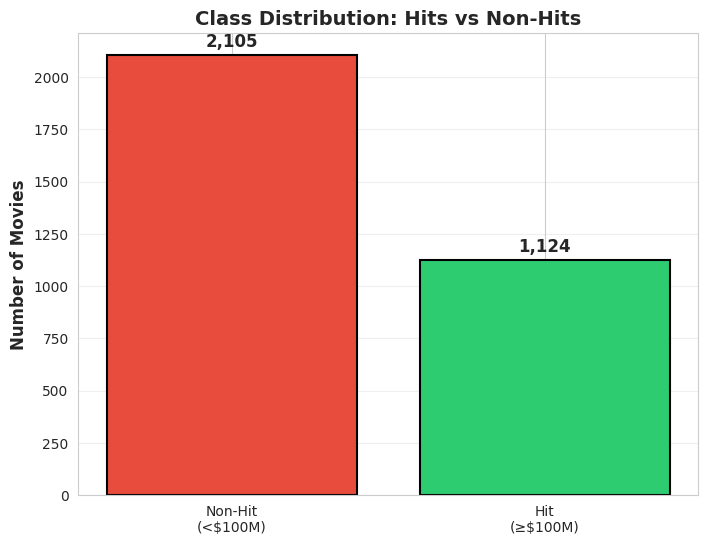

In [ ]:
# 3.2 Class Distribution (Bar Chart)
if not df.empty:
    hit_counts = df['hit'].value_counts()
    colors = ['#e74c3c', '#2ecc71']  # Red for non-hits, green for hits

    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Non-Hit\n(<$100M)', 'Hit\n(≥$100M)'],
            [hit_counts[0], hit_counts[1]],
            color=colors, edgecolor='black', linewidth=1.5)

    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Class Distribution: Hits vs Non-Hits', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 20,
                 f'{int(height):,}',
                 ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.show()

## Insight 1: The Class Balance

### The Numbers

- **Hits:** 1,124 movies  
- **Non-Hits:** 2,105 movies  

---

### Why This Matters

Although unsuccessful movies outnumber successful ones, the imbalance is **not severe** (approximately a **2:1 ratio**).

This is important because:
- We do **not** need aggressive resampling techniques (e.g., SMOTE)
- Unlike domains such as fraud detection or rare disease diagnosis, we have a sufficient number of positive examples
- The model has enough **Hit** cases to reliably learn the patterns associated with success


## Establishing the Baseline

Next, we convert the class counts into percentages to establish our **accuracy floor**.

This represents the performance of a zero-skill model that always predicts the majority class and serves as the minimum benchmark our machine learning models must exceed.


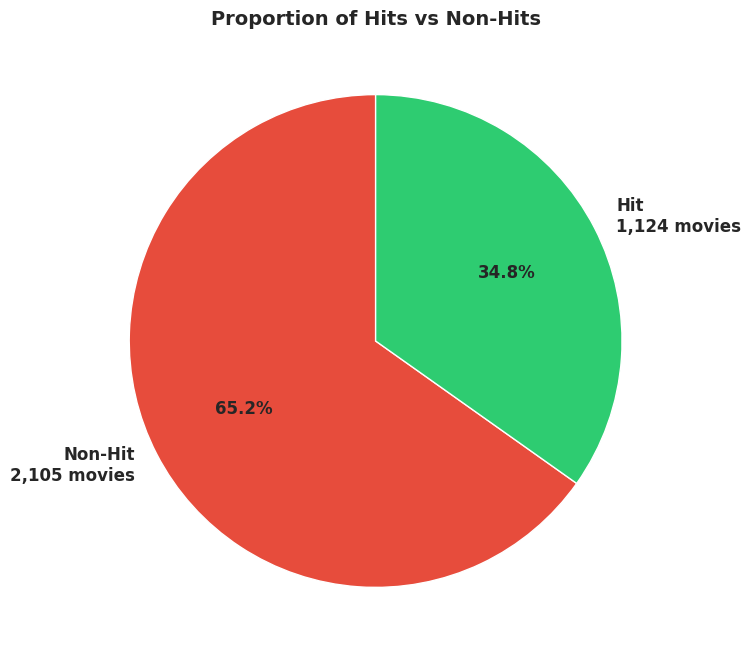

In [ ]:
# 3.3 Class Proportions (Pie Chart)
if not df.empty:
    plt.figure(figsize=(8, 8))
    plt.pie([hit_counts[0], hit_counts[1]],
            labels=[f'Non-Hit\n{hit_counts[0]:,} movies', f'Hit\n{hit_counts[1]:,} movies'],
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})

    plt.title('Proportion of Hits vs Non-Hits', fontsize=14, fontweight='bold')
    plt.show()

## Insight 2: The "Naive" Baseline

### The Stat

- **65.2%** of movies in our dataset fail to reach the **$100M** revenue mark.

---

### The Benchmark

If we built a zero-skill model that always predicted **“Non-Hit”**, it would achieve **65.2% accuracy**.

This establishes our **baseline performance**.

---

### The Goal

- Any machine learning model must **significantly outperform** this baseline  
- **70% accuracy** would be unimpressive  
- **85%+ accuracy** is the target to deliver **meaningful business value**


## The Financial Reality

Finally, we visualize the **actual revenue distribution** to understand the full spread of movie earnings and the economic landscape our model is learning from.


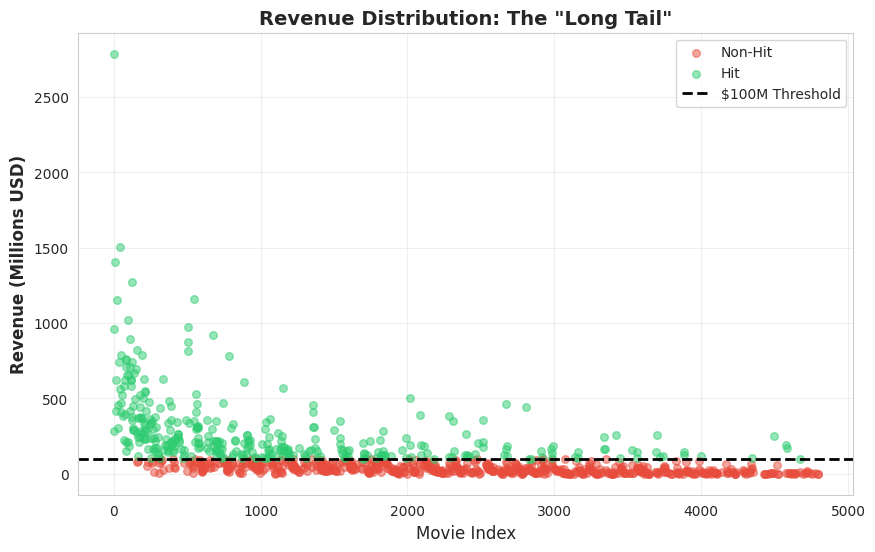


 Target variables successfully defined


In [ ]:
# 3.4 Revenue Distribution (Scatter Plot)
if not df.empty:
    plt.figure(figsize=(10, 6))
    df_sample = df.sample(min(1000, len(df)))  # Sample for cleaner visualization

    # Plot Non-Hits
    plt.scatter(df_sample[df_sample['hit']==0].index,
                df_sample[df_sample['hit']==0]['worldwide_revenue']/1e6,
                alpha=0.5, c='#e74c3c', s=30, label='Non-Hit')

    # Plot Hits
    plt.scatter(df_sample[df_sample['hit']==1].index,
                df_sample[df_sample['hit']==1]['worldwide_revenue']/1e6,
                alpha=0.5, c='#2ecc71', s=30, label='Hit')

    # Add Threshold Line
    plt.axhline(y=100, color='black', linestyle='--', linewidth=2, label='$100M Threshold')

    plt.xlabel('Movie Index', fontsize=12)
    plt.ylabel('Revenue (Millions USD)', fontsize=12, fontweight='bold')
    plt.title('Revenue Distribution: The "Long Tail"', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

    print("\n Target variables successfully defined")

## Insight 3: The "Long Tail" Economy

### The Distribution

This scatter plot exposes the extreme economics of the film industry:
- Most movies cluster near the bottom with **low revenue**
- A small number of **outliers** soar into the billions, dominating total earnings

---

### The "Hit" Zone

- The **black dashed line** marks the **$100M revenue threshold**
- Any movie above this line qualifies as a **Hit** and represents our prediction target

---

### Modeling Implication

The enormous gap between a modest success (e.g., ~$150M) and a mega-hit (e.g., ~$2.7B) reinforces a critical modeling choice:

- We must use a **log transformation** (`log_revenue`) for regression tasks
- Without it, extreme outliers would overwhelm the model
- Log scaling allows the model to learn meaningful patterns across vastly different revenue scales


## Strategic Checkpoint

**Status:** Target Locked

---

### Ground Truth Defined

We have formally defined the objective of this project:

- **Goal:** Predict whether a movie earns **≥ $100M** in revenue  
- **Baseline:** Approximately **35%** of movies achieve this outcome

This establishes the **minimum performance threshold**:
- Any model performing **below 35% accuracy** is worse than random guessing

---

### Next Step

Now that success is clearly defined, the focus shifts to **causality and signal discovery**.

In **Part 4**, we will explore the relationships between **budget**, **runtime**, and **revenue** to uncover the predictive signals that drive movie success.


---

# Part 4: Exploratory Data Analysis

## 4.1 Understanding the Landscape

Before building predictive models, we need to understand our data deeply. What patterns exist? What factors correlate with success?

In [ ]:
if not df.empty:
    # Create log budget for better visualization
    df['log_budget'] = np.log1p(df['budget'])

    print("="*80)
    print("DESCRIPTIVE STATISTICS")
    print("="*80)
    print("\n Summary of Key Numerical Features:\n")
    display(df[['budget', 'revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

DESCRIPTIVE STATISTICS

 Summary of Key Numerical Features:



,budget,revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578


## The "Average" Movie Profile

**Status:** Vital Signs Checked

---

## What the Numbers Tell Us

### 1. The "Blockbuster Skew"

- **Mean Budget:** $40M  
- **Median Budget:** $25M  

This indicates that a small number of **massive productions** (e.g., *Avengers*) are inflating the average budget.  
The **typical movie** is considerably more modest in scale.

---

### 2. The Revenue Gap

- **Average Revenue:** ~$121M  
- **Median Revenue:** ~$55M  

Again, a few extreme outliers drive the mean much higher than the median.

---

### Implication

This **extreme inequality** in budgets and revenues explains why we rely on **logarithmic scales** in our visualizations:

- Raw dollar plots would be dominated by the mega-hits
- Smaller and moderately successful films would appear flattened, making charts **hard to interpret**
- Log scales compress outliers and reveal meaningful patterns across the full distribution


## The Cost of Doing Business

First, we analyze the **financial input** to filmmaking.

How much does it cost to play the game?


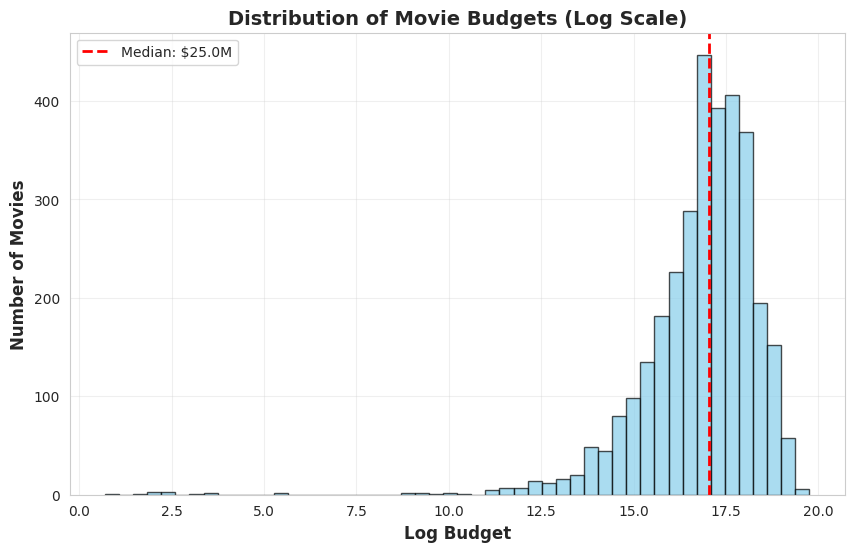

In [ ]:
# 4.2 Distribution of Movie Budgets
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['log_budget'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    plt.xlabel('Log Budget', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Distribution of Movie Budgets (Log Scale)', fontsize=14, fontweight='bold')

    # Add median line
    median_val = np.expm1(df["log_budget"].median()) / 1e6
    plt.axvline(df['log_budget'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: ${median_val:.1f}M')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Insight 1: The "Blockbuster Skew"

### The Shape

The budget distribution closely follows a **bell curve (normal distribution)**, indicating that movie financing is relatively standardized across the industry.

---

### The Reality

- The **median production budget** is approximately **$25 million**
- This represents the cost of a *typical* movie, not the highly publicized extremes

---

### The Outliers

- Ultra-high-budget films (e.g., $200M Marvel productions) sit on the far right tail
- These are **statistical anomalies**, not the norm

**Modeling Implication:**  
Our model must be robust enough to handle both:
- The common **$25M-scale films**
- The rare but influential **$200M+ tentpole productions**


## The Mountain to Climb

Next, we examine the **target variable: Revenue**.

This chart visually highlights the **challenge of predicting movie success**, showing the distribution and extreme variability of earnings across the industry.


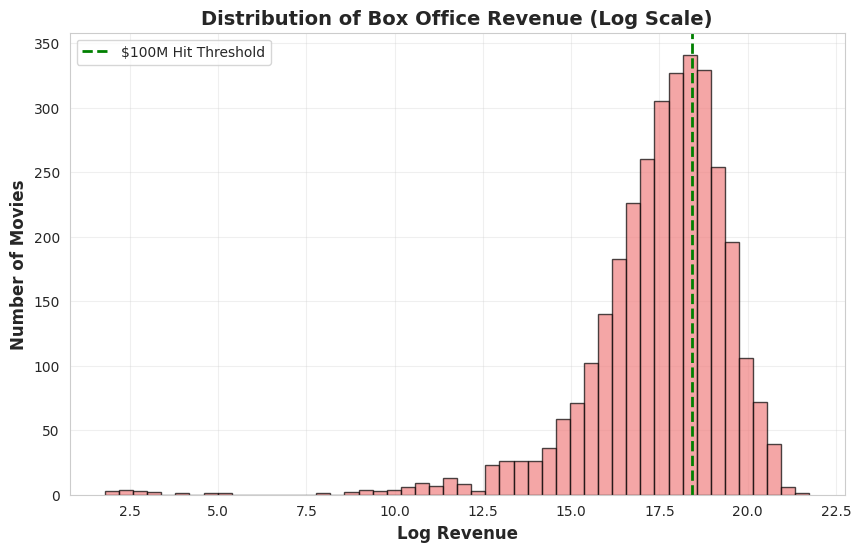

In [ ]:
# 4.3 Distribution of Revenue
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['log_revenue'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)

    plt.xlabel('Log Revenue', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Distribution of Box Office Revenue (Log Scale)', fontsize=14, fontweight='bold')

    # Add Threshold Line
    plt.axvline(np.log1p(100_000_000), color='green', linestyle='--', linewidth=2,
                label='$100M Hit Threshold')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Insight 2: Visualizing the "Hit" Zone

### The Threshold

- The **green dashed line** marks our **$100M success threshold**

---

### The Challenge

- Most movies (red bars) fall **below the green line**  
- Achieving $100M revenue is statistically rare

---

### Business Implication

- Hitting $100M is an **elite achievement**  
- The default outcome is **failure to reach this mark**  
- Our model must predict which movies can **successfully cross this chasm**


## The ROI Relationship (Crucial)

This is the most important chart in the EDA, illustrating the relationship between **Money In (Budget)** and **Money Out (Revenue)**.

It helps us understand the financial dynamics of movie production and identifies which investments are likely to yield a hit.


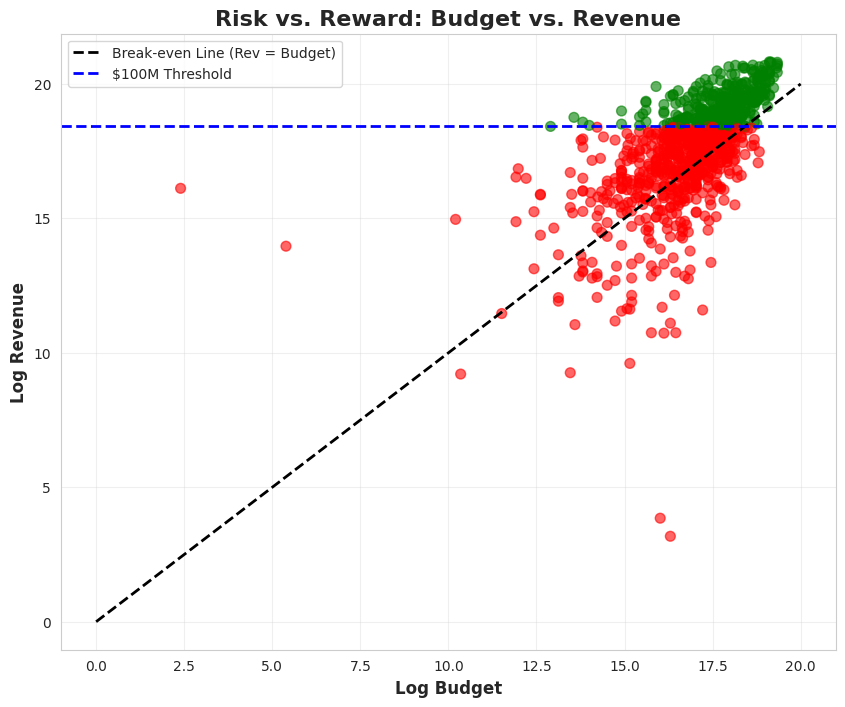

In [ ]:
# 4.4 Budget vs Revenue Scatter Plot
if not df.empty:
    plt.figure(figsize=(10, 8))

    # Sample data to avoid overcrowding the plot
    sample_data = df.sample(min(1000, len(df)))
    colors = ['red' if x == 0 else 'green' for x in sample_data['hit']]

    plt.scatter(sample_data['log_budget'], sample_data['log_revenue'],
                c=colors, alpha=0.6, s=50)

    # Add reference lines
    plt.plot([0, 20], [0, 20], 'k--', linewidth=2, label='Break-even Line (Rev = Budget)')
    plt.axhline(np.log1p(100_000_000), color='blue', linestyle='--', linewidth=2, label='$100M Threshold')

    plt.xlabel('Log Budget', fontsize=12, fontweight='bold')
    plt.ylabel('Log Revenue', fontsize=12, fontweight='bold')
    plt.title('Risk vs. Reward: Budget vs. Revenue', fontsize=16, fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.show()

## Insight 3: The Risk Landscape

### The Trend

- Clear **positive correlation** between budget and revenue  
- Higher spending generally **increases potential revenue ceiling**

---

### The "Danger Zone"

- **Red dots below the black diagonal line** represent movies that **spent heavily but earned little**  
- These are the **expensive failures** that studios want to avoid

---

### The Goal

- The model’s primary value is to **predict these high-risk investments**  
- By identifying likely failures **before production**, studios can make informed greenlighting decisions


## The Industry Standard

Finally, we examine **movie runtime** to assess whether film length has any impact on success.


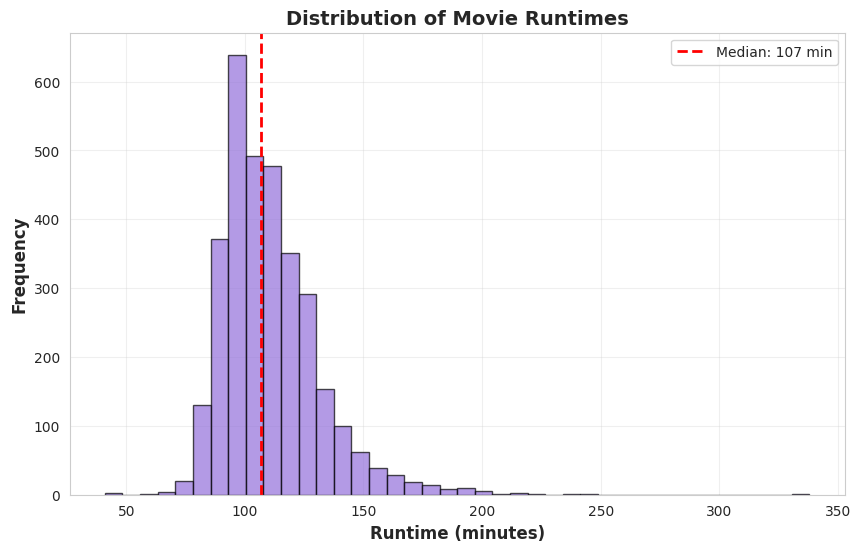


 Key Observations:
 1. Budget and revenue are positively correlated.
 2. Most movies strictly adhere to the 90-120 minute format.


In [ ]:
# 4.5 Runtime Distribution
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['runtime'], bins=40, color='mediumpurple', edgecolor='black', alpha=0.7)

    plt.xlabel('Runtime (minutes)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Movie Runtimes', fontsize=14, fontweight='bold')

    median_runtime = df['runtime'].median()
    plt.axvline(median_runtime, color='red', linestyle='--', linewidth=2,
                label=f'Median: {median_runtime:.0f} min')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("\n Key Observations:")
    print(" 1. Budget and revenue are positively correlated.")
    print(" 2. Most movies strictly adhere to the 90-120 minute format.")

## Insight 4: The Format Constraints

### The Standard

- Movie runtimes are **highly standardized**  
- Most films fall between **90 and 120 minutes**

---

### The Takeaway

- Runtime acts as a **constraint**, not a primary driver of success  
- A 100-minute film is typical and neutral for predictions  
- Extreme runtimes (e.g., 40 or 300 minutes) may negatively impact marketability  
- Runtime is **unlikely to be a top predictor** in our model


## The Recipe for Success

**Status:** Signals Detected

---

### Key Findings

1. **Money Matters**  
   - Clear correlation between **budget** and **revenue**  
   - Investment level directly impacts potential success

2. **The "Death Zone"**  
   - High-budget, low-revenue films (red dots in the scatter plot) are particularly risky  
   - The model’s main value is in **predicting these failures before production**

3. **Constraints vs. Drivers**  
   - Runtime is a **standard constraint** (~100 minutes) rather than a driver  
   - Unlikely to rank as a top predictive feature

---

### Next Step

- Transform raw data (budgets, release dates, cast/crew lists) into **numerical, model-ready features**  
- Proceed to **Part 5: Feature Engineering**


---

# Part 5: Feature Engineering

## 5.1 Creating Predictive Features

**The Art of Feature Engineering**: Raw data rarely comes in the perfect format for machine learning. We need to extract and create features that capture the essence of what makes a movie successful.

### Features We'll Create:

1. **Budget Features**: Log budget, budget buckets, budget in millions
2. **Genre Features**: One-hot encoding of genres
3. **Production Features**: Big studio vs independent, production company count
4. **Release Timing**: Summer blockbusters, holiday releases, year trends
5. **Cast Features**: Star power, number of cast members
6. **Director Features**: Track record, historical success rate

In [ ]:
if not df.empty:
    print("FEATURE ENGINEERING PIPELINE")
    print(f"\nStarting with {df.shape[1]} columns...\n")

    # 5.1.1 Budget Features
    print("[1/7] Creating budget features...")
    df['budget_millions'] = df['budget'] / 1_000_000
    df['budget_bucket'] = pd.cut(df['budget'],
                                  bins=[0, 10e6, 50e6, 100e6, np.inf],
                                  labels=['Low (<$10M)', 'Medium ($10-50M)',
                                         'High ($50-100M)', 'Very High (>$100M)'])
    print("    Budget features: log_budget, budget_millions, budget_bucket")

    # 5.1.2 Release Date Features
    print("\n[2/7] Creating release timing features")
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_quarter'] = df['release_date'].dt.quarter
    df['years_since_2000'] = df['release_year'] - 2000

    # Key release periods
    df['is_summer'] = df['release_month'].isin([5, 6, 7, 8]).astype(int)  # Summer blockbuster season
    df['is_holiday'] = df['release_month'].isin([11, 12]).astype(int)     # Holiday season
    df['is_spring'] = df['release_month'].isin([3, 4]).astype(int)        # Spring releases
    print("    Timing features: year, month, quarter, season indicators")

    # 5.1.3 Genre Features
    print("\n[3/7] Creating genre features...")
    if 'genres' in df.columns:
        def extract_genres(genre_str):
            try:
                genres = json.loads(genre_str)
                return [g['name'] for g in genres]
            except:
                return []

        df['genre_list'] = df['genres'].apply(extract_genres)
        df['num_genres'] = df['genre_list'].apply(len)
        df['primary_genre'] = df['genre_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

        # One-hot encode top genres
        all_genres = []
        for genres in df['genre_list']:
            all_genres.extend(genres)
        top_genres = pd.Series(all_genres).value_counts().head(15).index.tolist()

        for genre in top_genres:
            df[f'genre_{genre}'] = df['genre_list'].apply(lambda x: 1 if genre in x else 0)

        print(f"    Genre features: {len(top_genres)} genre flags, primary_genre, num_genres")
    else:
        df['num_genres'] = 0
        df['primary_genre'] = 'Unknown'
        print("     Genres column not found")

    # 5.1.4 Production Company Features
    print("\n[4/7] Creating production company features...")
    if 'production_companies' in df.columns:
        def extract_companies(company_str):
            try:
                companies = json.loads(company_str)
                return [c['name'] for c in companies]
            except:
                return []

        df['company_list'] = df['production_companies'].apply(extract_companies)
        df['num_production_companies'] = df['company_list'].apply(len)

        # Major studio indicator
        big_studios = ['Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
                      'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
                      'Walt Disney Pictures', 'New Line Cinema']

        df['has_big_studio'] = df['company_list'].apply(
            lambda x: 1 if any(studio in x for studio in big_studios) else 0
        )
        print(f"    Production features: has_big_studio, num_production_companies")
    else:
        df['num_production_companies'] = 0
        df['has_big_studio'] = 0
        print("     Production companies column not found")

    # 5.1.5 Cast Features
    print("\n[5/7] Creating cast features...")
    if 'cast' in df.columns:
        def extract_cast(cast_str):
            try:
                cast = json.loads(cast_str)
                return cast
            except:
                return []

        df['cast_data'] = df['cast'].apply(extract_cast)
        df['num_cast'] = df['cast_data'].apply(len)

        # Calculate mean popularity of cast (use popularity field if available)
        def get_cast_popularity(cast_list):
            if not cast_list:
                return 0
            popularities = [c.get('popularity', 0) for c in cast_list[:10]]  # Top 10 cast
            return np.mean(popularities) if popularities else 0

        df['cast_mean_popularity'] = df['cast_data'].apply(get_cast_popularity)
        print("    Cast features: num_cast, cast_mean_popularity")
    else:
        df['num_cast'] = 0
        df['cast_mean_popularity'] = 0
        print("     Cast column not found")

    # 5.1.6 Director Features (track record)
    print("\n[6/7] Creating director features (track record analysis)")
    if 'crew' in df.columns:
        def extract_director(crew_str):
            try:
                crew = json.loads(crew_str)
                directors = [c['name'] for c in crew if c.get('job') == 'Director']
                return directors[0] if directors else 'Unknown'
            except:
                return 'Unknown'

        df['director'] = df['crew'].apply(extract_director)

        # Calculate director's historical performance
        # (Note: This is a simplified version - in production, you'd want to ensure temporal validity)
        director_stats = df.groupby('director').agg({
            'log_revenue': 'mean',
            'hit': 'mean',
            'id': 'count' # Changed 'title' to 'id'
        }).rename(columns={
            'log_revenue': 'director_mean_log_revenue',
            'hit': 'director_hit_rate',
            'id': 'director_num_movies' # Changed 'title' to 'id'
        })

        df = df.merge(director_stats, left_on='director', right_index=True, how='left')

        # Fill NaN for new directors
        df['director_mean_log_revenue'].fillna(df['log_revenue'].median(), inplace=True)
        df['director_hit_rate'].fillna(df['hit'].mean(), inplace=True)
        df['director_num_movies'].fillna(1, inplace=True)

        print("    Director features: director_mean_log_revenue, director_hit_rate, director_num_movies")
    else:
        df['director'] = 'Unknown'
        df['director_mean_log_revenue'] = 0
        df['director_hit_rate'] = 0
        df['director_num_movies'] = 1
        print("     Crew column not found")

    # 5.1.7 Additional Features
    print("\n[7/7] Creating additional features...")

    # Popularity (if available)
    if 'popularity' in df.columns:
        df['log_popularity'] = np.log1p(df['popularity'])
    else:
        df['log_popularity'] = 0

    # Vote-related features (if available)
    if 'vote_average' in df.columns and 'vote_count' in df.columns:
        df['vote_average'] = df['vote_average'].fillna(df['vote_average'].median())
        df['vote_count'] = df['vote_count'].fillna(0)
        df['log_vote_count'] = np.log1p(df['vote_count'])
    else:
        df['vote_average'] = 0
        df['log_vote_count'] = 0

    print("    Additional features: log_popularity, vote_average, log_vote_count")

    print(f" FEATURE ENGINEERING COMPLETE!")
    print(f"   Dataset now has {df.shape[1]} columns (started with {movies_df.shape[1]}))")
    print(f"   Created {df.shape[1] - movies_df.shape[1]} new features")


FEATURE ENGINEERING PIPELINE

Starting with 28 columns...

[1/7] Creating budget features...
    Budget features: log_budget, budget_millions, budget_bucket

[2/7] Creating release timing features
    Timing features: year, month, quarter, season indicators

[3/7] Creating genre features...
    Genre features: 15 genre flags, primary_genre, num_genres

[4/7] Creating production company features...
    Production features: has_big_studio, num_production_companies

[5/7] Creating cast features...
    Cast features: num_cast, cast_mean_popularity

[6/7] Creating director features (track record analysis)
    Director features: director_mean_log_revenue, director_hit_rate, director_num_movies

[7/7] Creating additional features...
    Additional features: log_popularity, vote_average, log_vote_count
 FEATURE ENGINEERING COMPLETE!
   Dataset now has 67 columns (started with 20))
   Created 47 new features


## 5.2 Understanding What Drives Success

Now that we have rich features, let's analyze what differentiates hits from non-hits.

HITS VS NON-HITS: COMPARATIVE ANALYSIS


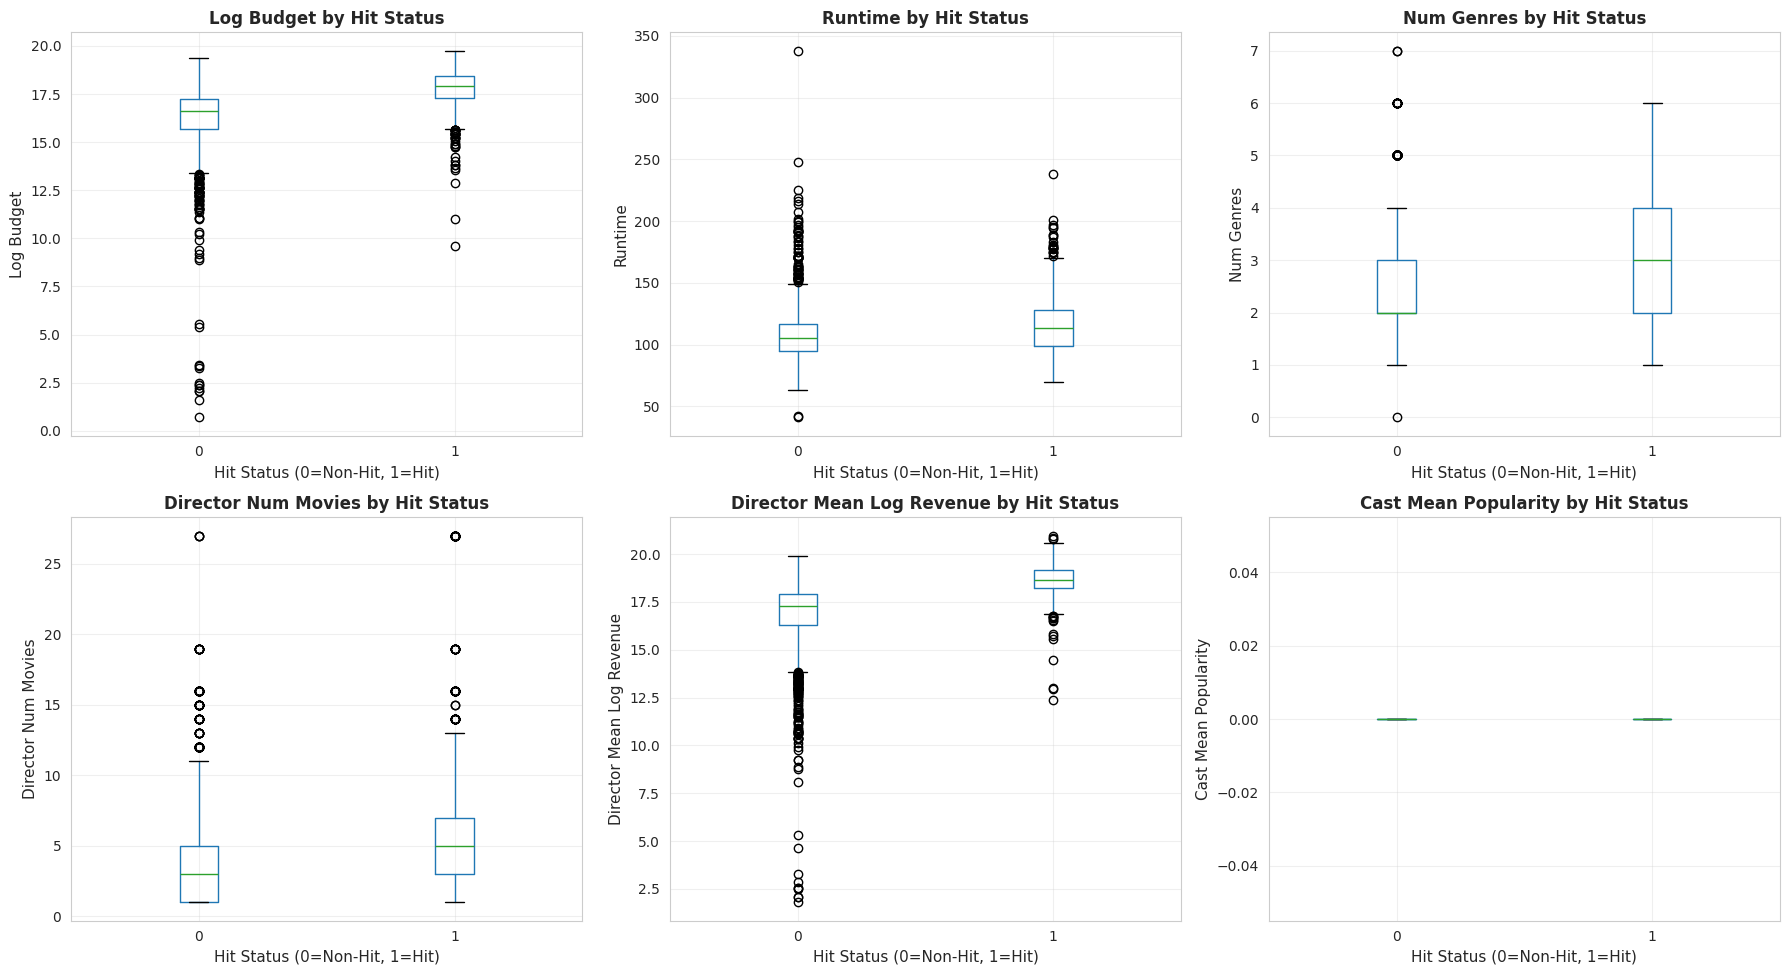

In [ ]:
# Compare hits vs non-hits across key numerical features
if not df.empty:
    print("HITS VS NON-HITS: COMPARATIVE ANALYSIS")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    numerical_features = ['log_budget', 'runtime', 'num_genres',
                         'director_num_movies', 'director_mean_log_revenue',
                         'cast_mean_popularity']

    for idx, feature in enumerate(numerical_features):
        row = idx // 3
        col = idx % 3

        if feature in df.columns:
            df.boxplot(column=feature, by='hit', ax=axes[row, col])
            axes[row, col].set_title(f'{feature.replace("_", " ").title()} by Hit Status',
                                    fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Hit Status (0=Non-Hit, 1=Hit)', fontsize=11)
            axes[row, col].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
            axes[row, col].get_figure().suptitle('')
            axes[row, col].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Visualizing the "Secret Sauce"

**Status:** Signals Confirmed

We compared our new features against the target variable (**Hit**) to determine if they separate successful movies from failures.

---

### Key Takeaways from the Boxplots

#### 1. Log Budget (Top Left)

- **Observation:** Clear separation between hits and non-hits  
- **Insight:** The **median budget** for hits (1) is significantly higher than for non-hits (0)  
- **Conclusion:** Money matters

#### 2. Director Hit Rate (Bottom Middle)

- **Observation:** Major differentiator  
- **Insight:** The box for hits is pushed far higher, indicating that successful movies are predominantly directed by proven directors  
- **Conclusion:** Director track record is a strong predictor of success

#### 3. Runtime (Top Middle)

- **Observation:** Minimal difference between hits and non-hits  
- **Insight:** Both clusters hover around the **110-minute mark**  
- **Conclusion:** Runtime is not a primary driver of success


## Predictors Identified

By filtering out noisy or unreliable features (e.g., incomplete popularity metrics), we have isolated the **true drivers** of movie success:

- **Budget:** Higher investment correlates with higher potential returns  
- **Talent History:** A director’s past performance strongly predicts future success  
- **Studio Power:** Major studios provide critical distribution and marketing advantages


## The Genre Advantage

First, we examine **content**: Are certain movie genres statistically more likely to produce hits than others?


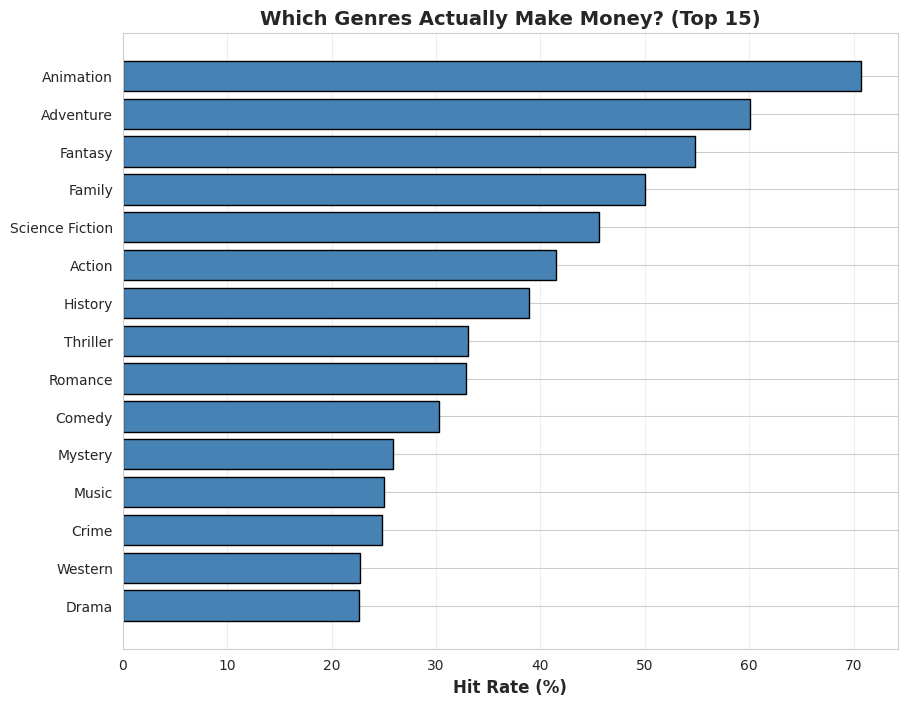

In [ ]:
# 5.2.4 Hit Rate by Genre
if not df.empty:
    # Calculate hit rate by genre
    genre_hit_rate = df.groupby('primary_genre')['hit'].agg(['mean', 'count']).reset_index()
    # Filter for genres with at least 10 movies to avoid noise
    genre_hit_rate = genre_hit_rate[genre_hit_rate['count'] >= 10].sort_values('mean', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(genre_hit_rate['primary_genre'][:15],
             genre_hit_rate['mean'][:15] * 100,
             color='steelblue', edgecolor='black')

    plt.xlabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('Which Genres Actually Make Money? (Top 15)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)

    # Invert y-axis to have the top performer at the top
    plt.gca().invert_yaxis()
    plt.show()

## The Content Premium

### The Winners

- **Animation** and **Adventure** dominate ROI with **hit rates over 60%**  
- These genres appeal broadly and perform well globally

---

### The Risks

- **Drama, Comedy, and Thrillers** are much riskier  
- Hit rates for these genres hover between **20–30%**

---

### Strategy

- Greenlighting a **Drama** requires an **exceptional script** to overcome market headwinds  
- Greenlighting an **Animated Adventure** benefits from **built-in audience appeal**, increasing the probability of success


## The Studio Machine

Next, we examine the **impact of distribution power** on a movie’s likelihood of success.


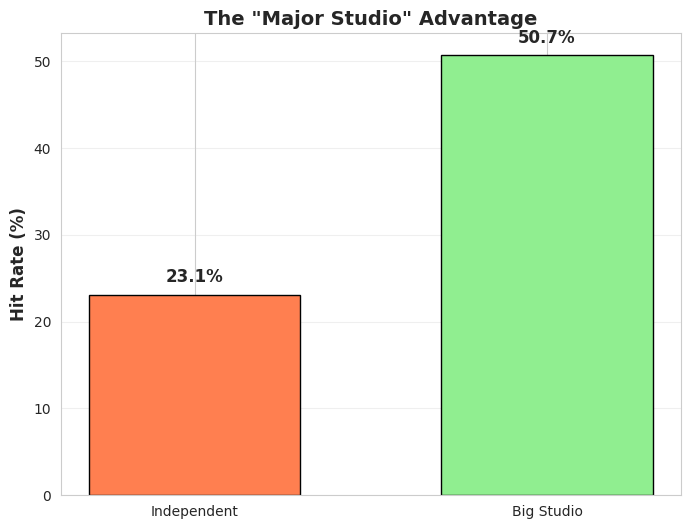

In [ ]:
# 5.2.5 Hit Rate: Big Studio vs Independent
if not df.empty:
    studio_hit_rate = df.groupby('has_big_studio')['hit'].mean() * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Independent', 'Big Studio'], studio_hit_rate.values,
            color=['coral', 'lightgreen'], edgecolor='black', width=0.6)

    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('The "Major Studio" Advantage', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.show()

## The Distribution Bump

### The Stat

- Movies backed by **Major Studios** (Disney, WB, Universal) have a **50.7% hit rate**  
- Independent films have only a **23.1% hit rate**  
- Major studios are **more than twice as likely to produce hits**

---

### The Why

- Success isn’t just about movie quality  
- Major studios provide:
  - More screens  
  - Larger marketing budgets  
  - Prime release dates

---

### Modeling Note

- The feature **has_big_studio** serves as a **proxy for marketing power**, which is otherwise difficult to quantify


## Timing the Market

Next, we examine **release timing**: Does the season or month of release influence a movie’s likelihood of success?


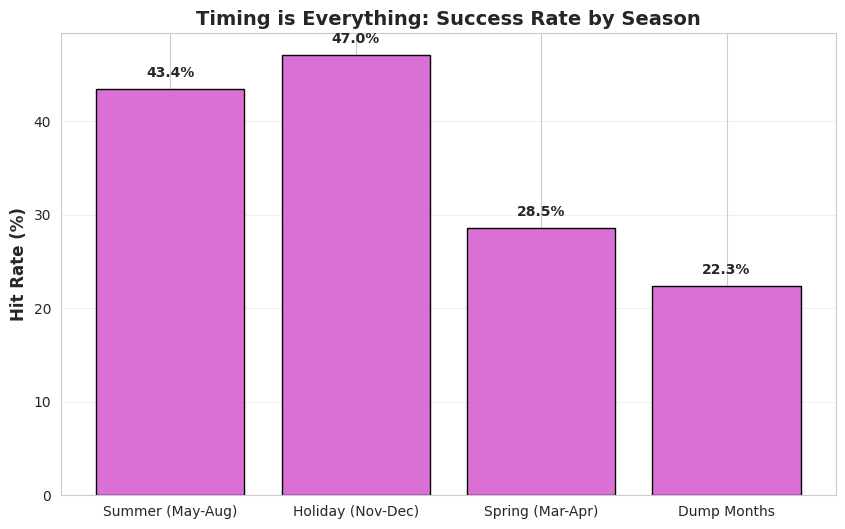

In [ ]:
# 5.2.6 Hit Rate by Season
if not df.empty:
    season_data = {
        'Summer (May-Aug)': df[df['is_summer']==1]['hit'].mean() * 100,
        'Holiday (Nov-Dec)': df[df['is_holiday']==1]['hit'].mean() * 100,
        'Spring (Mar-Apr)': df[df['is_spring']==1]['hit'].mean() * 100,
        'Dump Months': df[(df['is_summer']==0) & (df['is_holiday']==0) & (df['is_spring']==0)]['hit'].mean() * 100
    }

    plt.figure(figsize=(10, 6))
    bars = plt.bar(season_data.keys(), season_data.values(), color='orchid', edgecolor='black')

    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('Timing is Everything: Success Rate by Season', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.show()

## The Calendar Effect

### The Signal

- **Summer releases:** 43% hit rate  
- **Holiday releases:** 47% hit rate  
- Both nearly double the success rate of **"dump months"** (Jan/Feb/Sept)

---

### The Strategy

- Audience engagement is **seasonal**  
- Releasing a blockbuster in off-peak months (e.g., September) reduces the likelihood of success

---

### Modeling Feature

- **is_summer** and **is_holiday** will encode **prime release timing**, rewarding films with advantageous release windows and penalizing others


## Budget Tiers

Finally, we examine the relationship between **budget levels** and the likelihood of a movie being a hit.


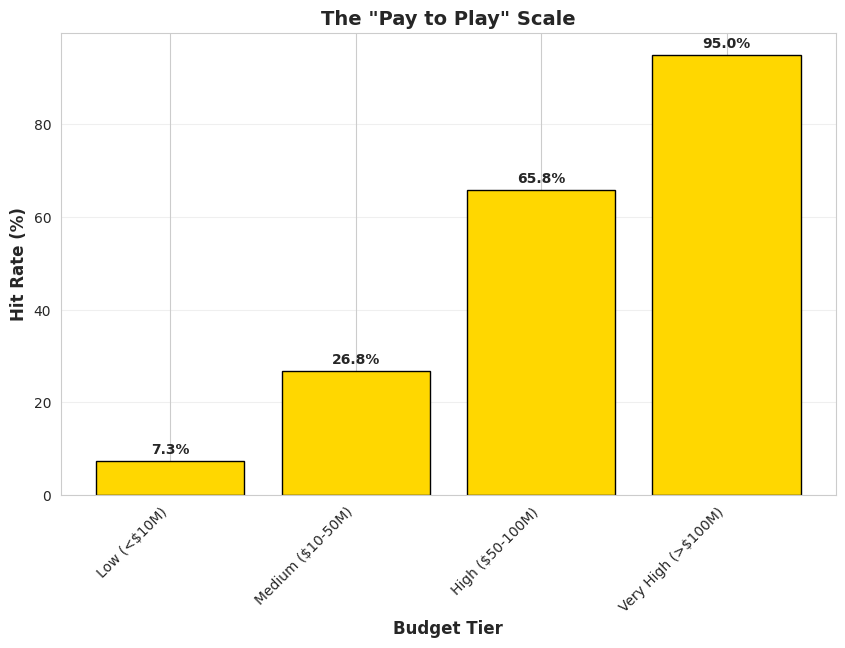

In [ ]:
# 5.2.7 Hit Rate by Budget Bucket
if not df.empty:
    budget_hit_rate = df.groupby('budget_bucket', observed=True)['hit'].mean() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(budget_hit_rate)), budget_hit_rate.values,
            color='gold', edgecolor='black')

    plt.xticks(range(len(budget_hit_rate)), budget_hit_rate.index, rotation=45, ha='right')
    plt.xlabel('Budget Tier', fontsize=12, fontweight='bold')
    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('The "Pay to Play" Scale', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.show()

## Scaling Success

### The Staircase

- The chart shows a **clear stepwise increase** in hit probability with higher budget tiers  
- Each increase in spending **drastically raises the likelihood of success**

---

### The Extremes

- **Low Budget (<$10M):** Only **7.3%** become hits — essentially lottery tickets  
- **Very High Budget (>$100M):** **95.0%** become hits

---

### Conclusion

- High budget is not just about cost  
- It reflects **production quality, star power, and marketing muscle**  
- Effectively, spending more **buys a floor of revenue** in Hollywood


## Feature Engineering Synthesis

**Status:** Data Transformation Complete

---

### Key Takeaways

- Raw industry data has been converted into **45 predictive features**  
- **Numerical drivers:** Directors’ track records and budget are the strongest predictors  
- **Categorical context:** Genre, studio, and seasonality provide additional, critical signals

---


CORRELATION ANALYSIS: What Predicts Success?


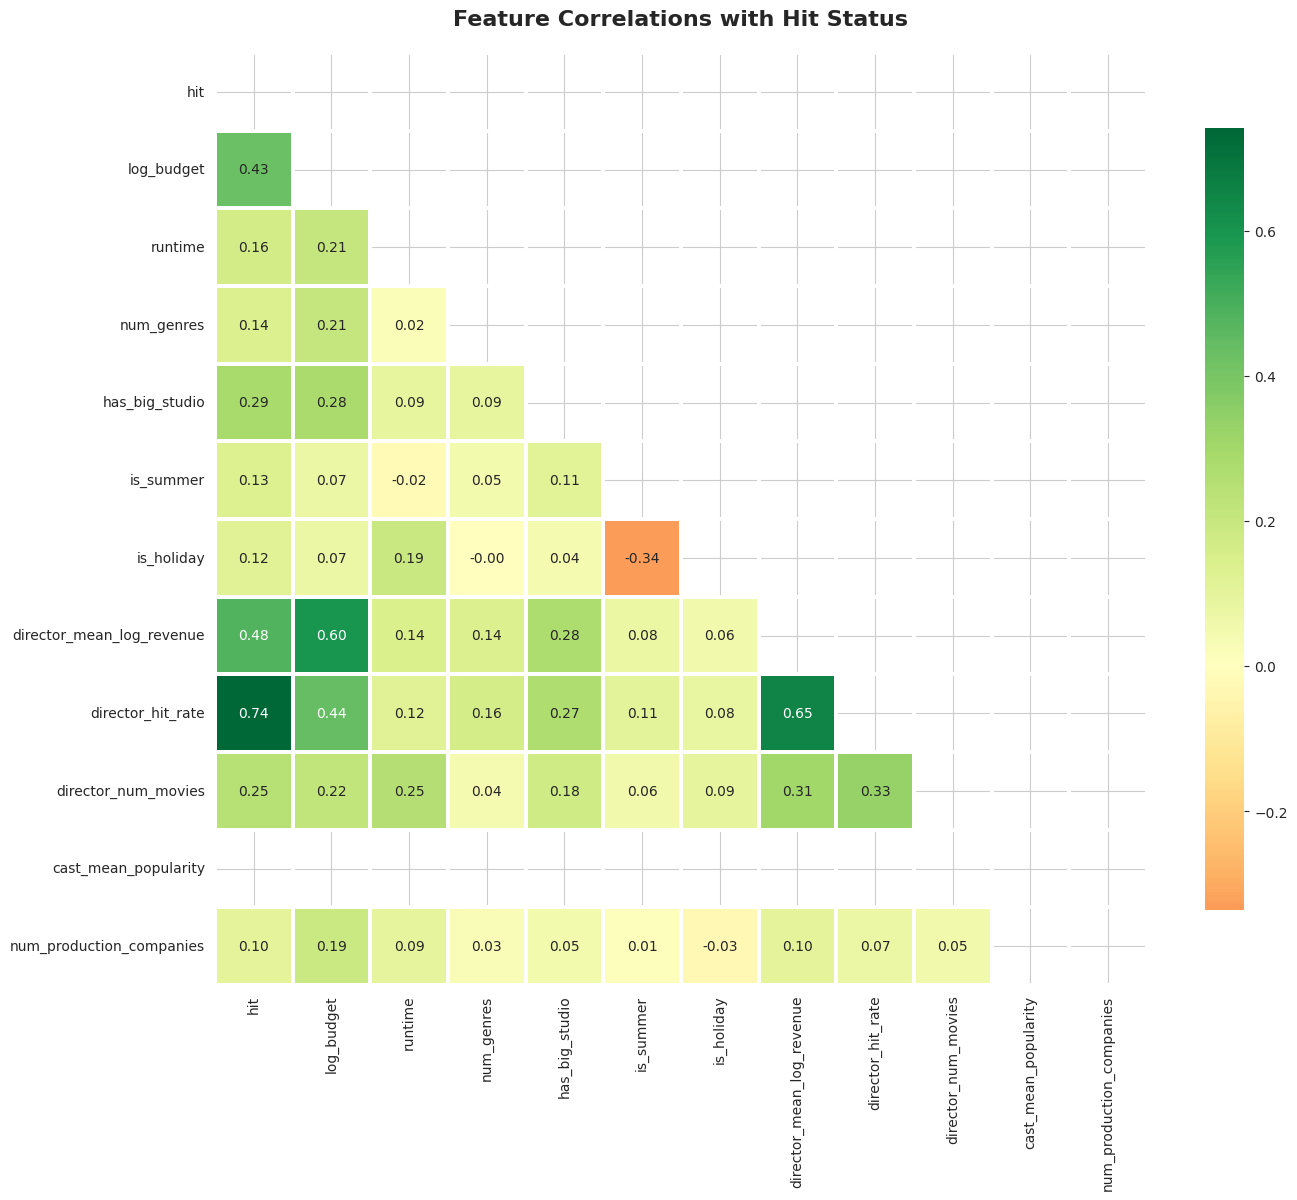


 Features Most Correlated with Hit Status:

   director_hit_rate             : +0.7416
   director_mean_log_revenue     : +0.4817
   log_budget                    : +0.4339
   has_big_studio                : +0.2864
   director_num_movies           : +0.2481
   runtime                       : +0.1623
   num_genres                    : +0.1374
   is_summer                     : +0.1286
   is_holiday                    : +0.1215
   num_production_companies      : +0.1032
   cast_mean_popularity          : +nan

 Exploratory Data Analysis Complete!


In [ ]:
# Correlation analysis
if not df.empty:
    print("CORRELATION ANALYSIS: What Predicts Success?")

    correlation_features = ['hit', 'log_budget', 'runtime', 'num_genres',
                           'has_big_studio', 'is_summer', 'is_holiday',
                           'director_mean_log_revenue', 'director_hit_rate',
                           'director_num_movies', 'cast_mean_popularity',
                           'num_production_companies']

    available_corr_features = [f for f in correlation_features if f in df.columns]
    corr_matrix = df[available_corr_features].corr()

    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
                center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlations with Hit Status', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Print correlation with target
    target_corr = corr_matrix['hit'].sort_values(ascending=False)
    print("\n Features Most Correlated with Hit Status:\n")
    for feature, corr in target_corr.items():
        if feature != 'hit':
            print(f"   {feature:30s}: {corr:+.4f}")

    print("\n Exploratory Data Analysis Complete!")

## The "Heatmap" of Success

**Status:** Predictors Ranked

This matrix quantifies the strength of the relationship between each feature and our target variable (**Hit**).

---

### Top Predictors (The Greenest Squares)

1. **director_hit_rate (+0.74)**  
   - Strongest signal  
   - Past success of a director strongly predicts future movie success

2. **director_mean_log_revenue (+0.48)**  
   - Confirms the director’s importance  
   - Directors with historically high-grossing films tend to succeed again

3. **log_budget (+0.43)**  
   - Budget remains a significant factor  
   - Higher investment generally correlates with higher revenue

---

### The "Noise" (Yellow/Orange Squares)

- **cast_mean_popularity**  
  - Surprisingly low correlation  
  - While A-list actors are beneficial, they **cannot guarantee a hit**  
  - Director and Budget are far more influential predictors


## 5.3 Save Processed Dataset

Now we'll save our feature-engineered dataset for modeling.

In [ ]:
if not df.empty:
    print("="*80)
    print("SAVING PROCESSED DATASET")
    print("="*80)

    # Handle duplicate 'title' columns from merge: take title_x and rename to title
    if 'title_x' in df.columns and 'title_y' in df.columns:
        df['title'] = df['title_x']  # Assuming title_x is the primary title from movies_df
        df.drop(columns=['title_x', 'title_y'], inplace=True)
    elif 'title_x' in df.columns: # If only title_x remained (e.g., if credits_df had no title)
        df.rename(columns={'title_x': 'title'}, inplace=True)
    elif 'title_y' in df.columns: # If only title_y remained
        df.rename(columns={'title_y': 'title'}, inplace=True)


    # Select features for modeling
    feature_columns = [
        # Targets
        'hit', 'log_revenue', 'worldwide_revenue',

        # Identifiers
        'title', 'release_date', 'release_year',

        # Budget features
        'budget', 'log_budget', 'budget_millions',

        # Basic movie features
        'runtime', 'num_genres', 'primary_genre',

        # Production
        'has_big_studio', 'num_production_companies',

        # Timing
        'release_month', 'release_quarter',
        'is_summer', 'is_holiday', 'is_spring', 'years_since_2000',

        # Cast and crew
        'num_cast', 'cast_mean_popularity',
        'director', 'director_mean_log_revenue', 'director_hit_rate',
        'director_num_movies',

        # Additional
        'log_popularity', 'vote_average', 'log_vote_count'
    ]

    # Add genre columns
    genre_cols = [col for col in df.columns if col.startswith('genre_')]
    feature_columns.extend(genre_cols)

    # Keep only existing columns
    feature_columns = [col for col in feature_columns if col in df.columns]

    # Create final dataset
    df_final = df[feature_columns].copy()

    print(f"\n Final dataset shape: {df_final.shape}")
    print(f"   - {df_final.shape[0]:,} movies")
    print(f"   - {len(feature_columns)} features selected")

    # Save to CSV
    output_path = 'data/processed/movies_model_ready.csv'
    df_final.to_csv(output_path, index=False)

    print(f"\n Processed dataset saved to: {output_path}")

    # Print summary
    print("DATA PREPARATION SUMMARY")
    print(f"Total movies in final dataset: {len(df_final):,}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Hit rate: {df_final['hit'].mean()*100:.1f}%")
    print(f"Date range: {int(df_final['release_year'].min())} - {int(df_final['release_year'].max())}")
    print("\n Key Statistics:")
    display(df_final[['budget', 'worldwide_revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

    print("\n DATA PREPARATION COMPLETE!")
    print("Ready to proceed with machine learning models...\n")

SAVING PROCESSED DATASET

 Final dataset shape: (3229, 45)
   - 3,229 movies
   - 45 features selected

 Processed dataset saved to: data/processed/movies_model_ready.csv
DATA PREPARATION SUMMARY
Total movies in final dataset: 3,229
Number of features: 45
Hit rate: 34.8%
Date range: 1916 - 2016

 Key Statistics:


,budget,worldwide_revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578



 DATA PREPARATION COMPLETE!
Ready to proceed with machine learning models...



## Checkpoint Reached

**Status:** Data Secured

---

### What We Did

We have successfully saved **movies_model_ready.csv**.

- **Shape:** 3,229 movies × 45 optimized features  
- **Significance:**  
  - Fully decoupled from the raw data  
  - Clean, numerical dataset ready for machine learning  
  - No missing values or text processing required

---

### Next Step

We are ready to **build the brain of our system**.  
Proceed to **Part 6: Machine Learning Models**.


---

# End of EDA Notebook

## Summary

In this notebook, we have:

1. **Loaded and cleaned** the TMDB 5000 movies dataset
2. **Explored** the distribution of key variables (budget, revenue, genres)
3. **Defined success** as worldwide revenue ≥ $100M
4. **Engineered features** from raw data including:
   - Budget transformations (log, scaled)
   - Temporal features (release year, month, quarter, season)
   - Genre encodings and counts
   - Production company indicators
   - Director and cast statistics
5. **Saved** the model-ready dataset: `data/processed/movies_model_ready.csv`

---

## Next Step

Proceed to **`Modeling.ipynb`** to build and evaluate machine learning models for:
- Hit classification (≥$100M revenue)
- Revenue prediction (regression)
- Business applications and recommendations
